# Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="darkgrid", palette="pastel")

import holidays

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from skopt import BayesSearchCV
from skopt.space import Real, Integer

## Reading and Explore the Data

In [2]:
date_columns = ["Order Date", "Ship Date"]
df = pd.read_csv("data.csv", encoding="ISO-8859-1", parse_dates=date_columns)

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,is_holiday,holiday_name
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,False,NaN
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,False,NaN
2,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,False,NaN
3,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694,False,NaN
4,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092,False,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   datetime64[ns]
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

In [5]:
df.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121,2121,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,2016-04-30 03:54:13.748231680,2016-05-04 01:54:44.299858432,55726.556341,349.834887,3.785007,0.173923,8.699327
min,1.000000,2014-01-06 00:00:00,2014-01-10 00:00:00,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,2015-05-26 00:00:00,2015-05-31 00:00:00,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,2016-06-20 00:00:00,2016-06-23 00:00:00,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,2017-05-14 00:00:00,2017-05-18 00:00:00,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,4416.174000,14.000000,0.700000,1013.127000
std,2885.740258,NaN,NaN,32261.888225,503.179145,2.251620,0.181547,136.049246


In [6]:
df.describe(include="object")

,Order ID,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name,holiday_name
count,2121,2121,2121,2121,2121,2121,2121,2121,2121,2121,2121,2121,2121,158
unique,1764,4,707,707,3,1,371,48,4,375,1,4,380,17
top,US-2015-129007,Standard Class,SV-20365,Seth Vernon,Consumer,United States,New York City,California,West,FUR-FU-10004270,Furniture,Furnishings,KI Adjustable-Height Table,Christmas Day
freq,4,1248,15,15,1113,2121,192,444,707,16,2121,957,18,18


In [7]:
df.isna().sum()

Row ID              0
Order ID            0
Order Date          0
Ship Date           0
Ship Mode           0
Customer ID         0
Customer Name       0
Segment             0
Country             0
City                0
State               0
Postal Code         0
Region              0
Product ID          0
Category            0
Sub-Category        0
Product Name        0
Sales               0
Quantity            0
Discount            0
Profit              0
is_holiday          0
holiday_name     1963
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

## Data visualization

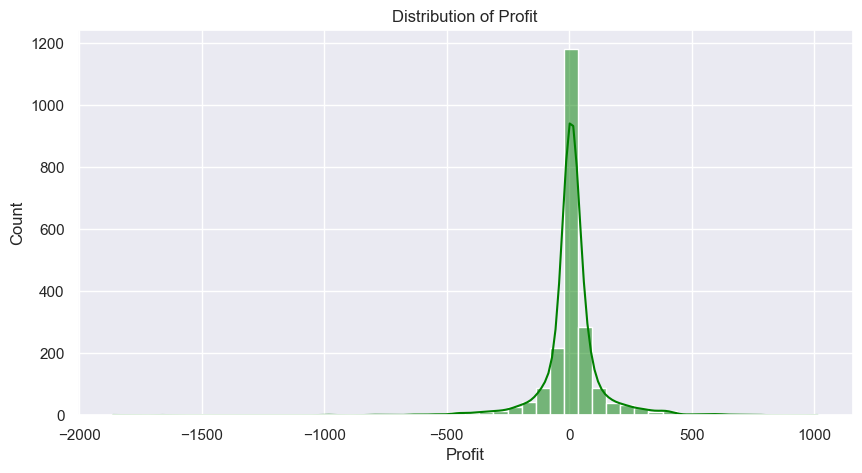

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Profit'], bins=50, kde=True, color='green')
plt.title("Distribution of Profit")
plt.xlabel("Profit")
plt.ylabel("Count")
plt.show()

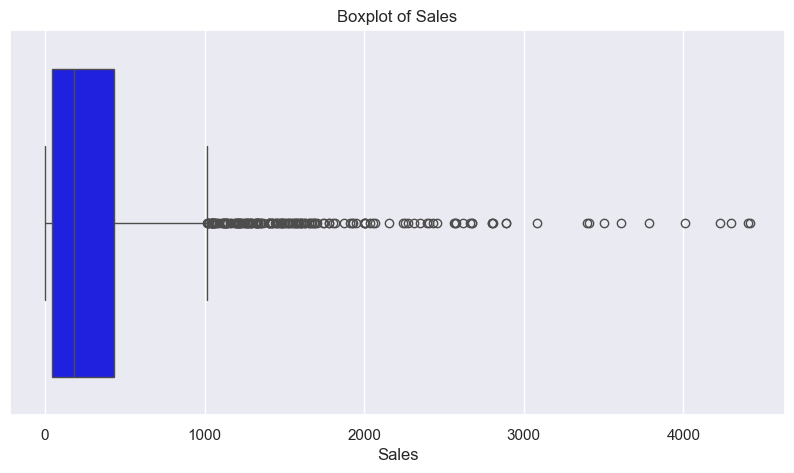

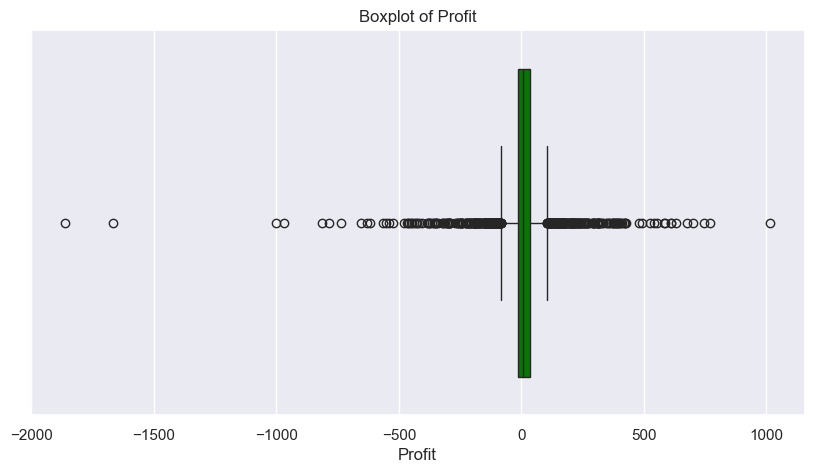

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Sales'], color='blue')
plt.title("Boxplot of Sales")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Profit'], color='green')
plt.title("Boxplot of Profit")
plt.show()

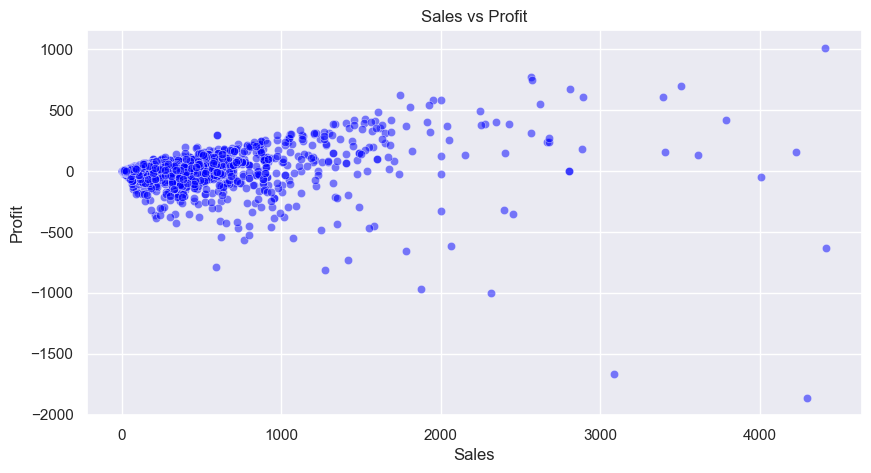

In [11]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Sales'], y=df['Profit'], alpha=0.5, color='blue')
plt.title("Sales vs Profit")
plt.xlabel("Sales")
plt.ylabel("Profit")
plt.show()

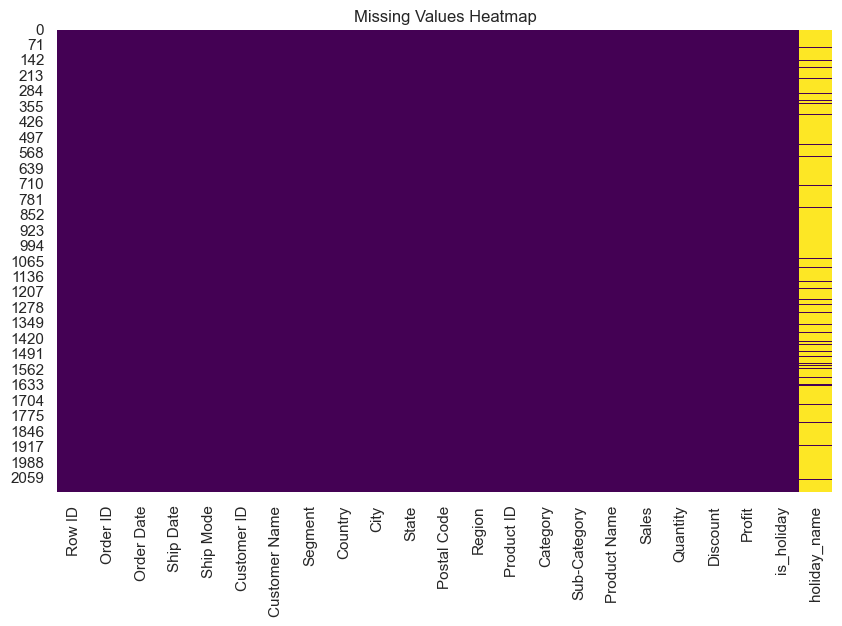

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

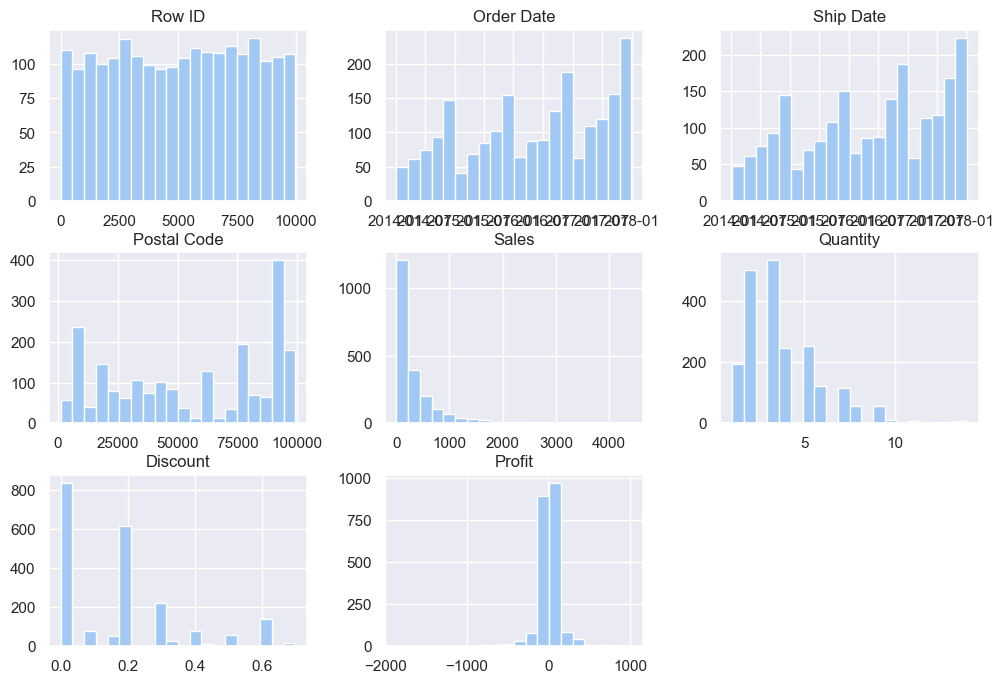

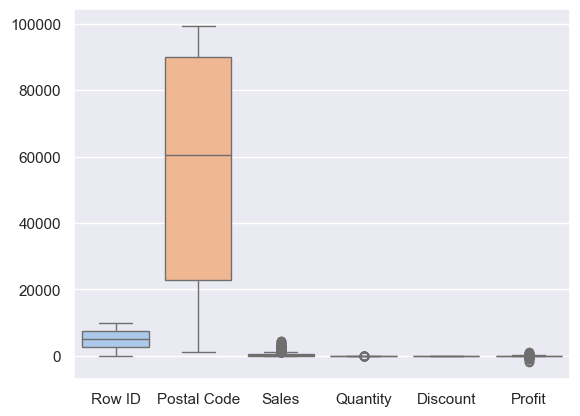

In [13]:
df.hist(figsize=(12, 8), bins=20)
plt.show()

# Boxplots to check for outliers
sns.boxplot(data=df.select_dtypes(include=['number']))
plt.show()

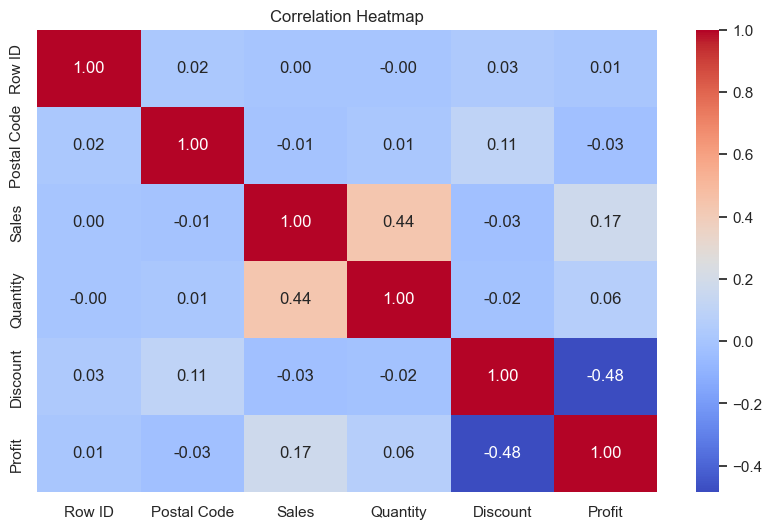

In [14]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

/var/folders/r_/p2ff2v2d5d30yk4nm7ky1gfh0000gn/T/ipykernel_83743/100789197.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sub-Category', y='Sales', data=sub_category_sales, palette='viridis')


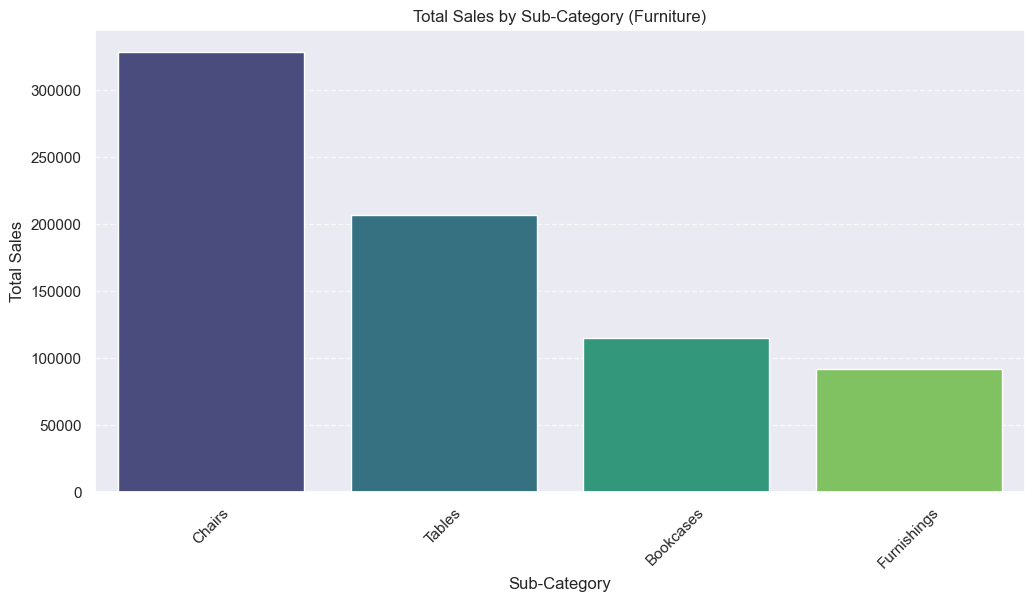

In [15]:
# Aggregate sales by sub-category
sub_category_sales = df.groupby('Sub-Category', as_index=False)['Sales'].sum()

# Sort by sales
sub_category_sales = sub_category_sales.sort_values(by='Sales', ascending=False)

# Plot sales per sub-category
plt.figure(figsize=(12, 6))
sns.barplot(x='Sub-Category', y='Sales', data=sub_category_sales, palette='viridis')
plt.title('Total Sales by Sub-Category (Furniture)')
plt.xlabel('Sub-Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

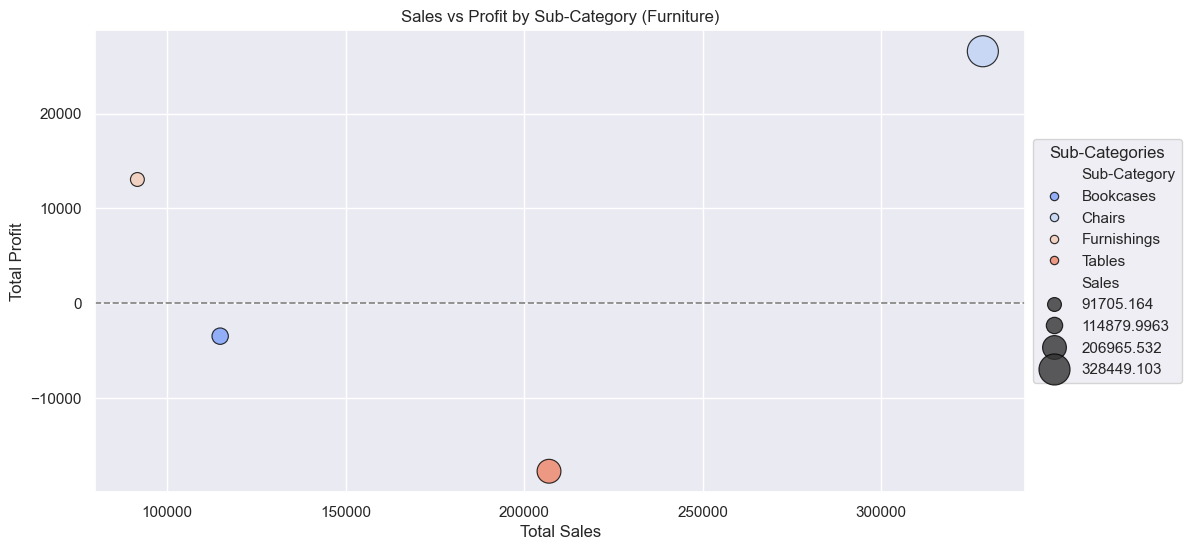

In [16]:
# Aggregate sales and profit by sub-category
sub_category_profit = df.groupby('Sub-Category', as_index=False)[['Sales', 'Profit']].sum()

# Create the scatter plot
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    x='Sales', y='Profit', hue='Sub-Category', size='Sales', 
    sizes=(100, 500), data=sub_category_profit, palette='coolwarm', edgecolor='black', alpha=0.8
)

# Add reference lines at zero profit
plt.axhline(0, color='gray', linestyle='--', linewidth=1.2)

plt.title('Sales vs Profit by Sub-Category (Furniture)')
plt.xlabel('Total Sales')
plt.ylabel('Total Profit')
plt.grid(True)

# Move the legend to the right side
plt.legend(title="Sub-Categories", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


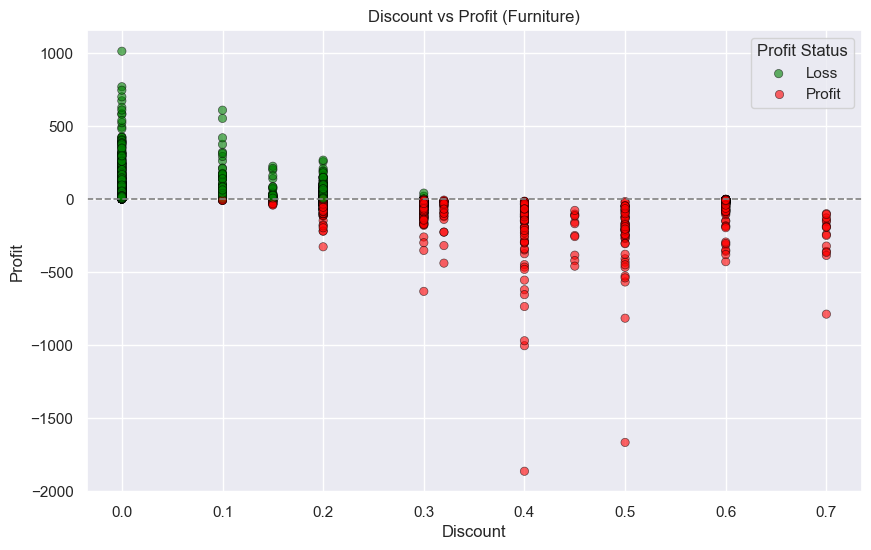

In [17]:
# Create scatter plot for Discount vs Profit with color distinction
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df['Discount'], y=df['Profit'], hue=df['Profit'] > 0, palette={True: 'green', False: 'red'},
    alpha=0.6, edgecolor='black'
)

# Add reference line at zero profit
plt.axhline(0, color='gray', linestyle='--', linewidth=1.2)

plt.title('Discount vs Profit (Furniture)')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.legend(title="Profit Status", labels=["Loss", "Profit"])
plt.grid(True)
plt.show()


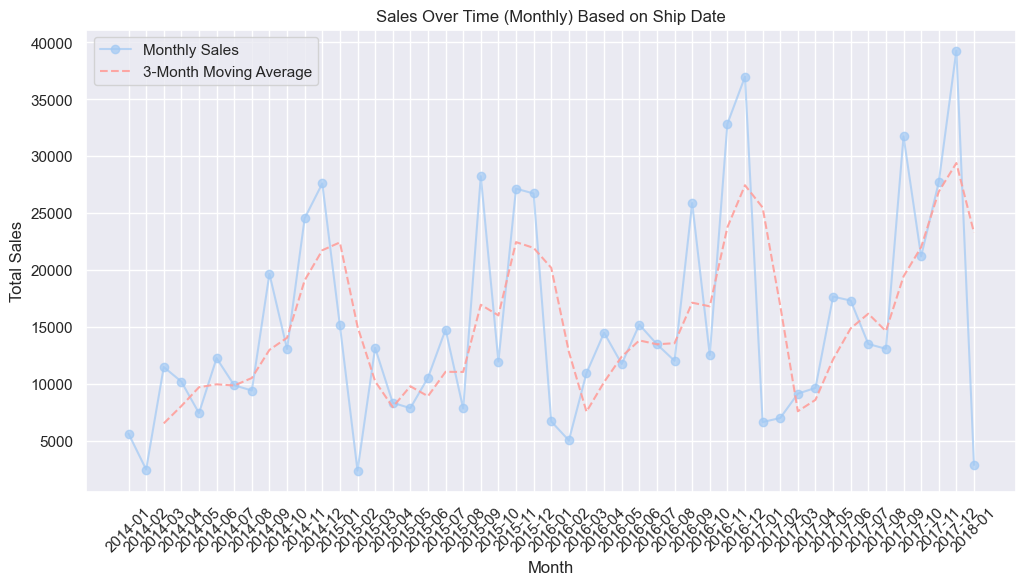

In [18]:
# Convert Ship Date to datetime
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Aggregate sales by month based on Ship Date
df['Month'] = df['Ship Date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Sales'].sum()

# Plot Monthly Sales Trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index.astype(str), monthly_sales, marker='o', linestyle='-', color='b', alpha=0.7, label='Monthly Sales')

# Add moving average to smooth the trend
rolling_avg = monthly_sales.rolling(window=3).mean()
plt.plot(monthly_sales.index.astype(str), rolling_avg, linestyle='--', color='r', alpha=0.9, label='3-Month Moving Average')

plt.title('Sales Over Time (Monthly) Based on Ship Date')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


/var/folders/r_/p2ff2v2d5d30yk4nm7ky1gfh0000gn/T/ipykernel_83743/2505780882.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_holiday', y='Sales', data=avg_sales, palette='coolwarm')


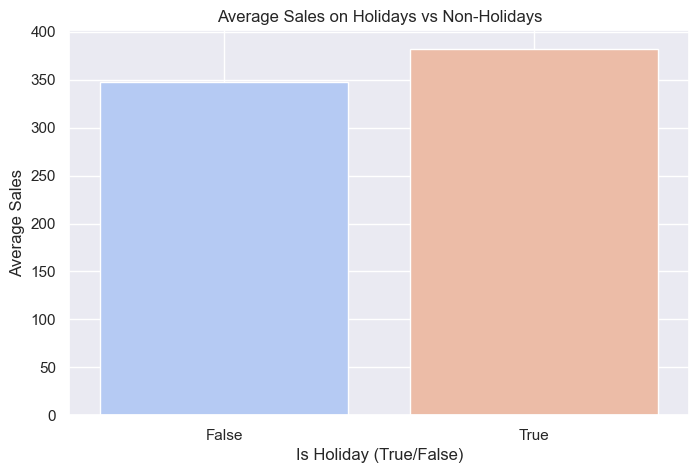

In [19]:
# Compute average sales for holidays vs non-holidays
avg_sales = df.groupby('is_holiday')['Sales'].mean().reset_index()

# Create a bar plot to compare average sales
plt.figure(figsize=(8, 5))
sns.barplot(x='is_holiday', y='Sales', data=avg_sales, palette='coolwarm')

plt.title('Average Sales on Holidays vs Non-Holidays')
plt.xlabel('Is Holiday (True/False)')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()


## Feature Creation

In [20]:
df = (df.groupby("Order Date")
      .agg({"Sales": "sum"})
      .reset_index()
      .set_index("Order Date")
      .sort_index())

In [21]:
df.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 889 entries, 2014-01-06 to 2017-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   889 non-null    float64
dtypes: float64(1)
memory usage: 13.9 KB


In [23]:
def add_time_features(df):
    df = df.copy()

    df["Day of Week"] = df.index.dayofweek

    df["Month"] = df.index.month
    df["Month Sin"] = np.sin(df["Month"] * (2 * np.pi / 12))

    df["Day"] = df.index.day
    df["Day Sin"] = np.sin(df["Day"] * (2 * np.pi / 31))

    df["Day of Year"] = df.index.dayofyear
    df["Quarter"] = df.index.quarter
    df["Year"] = df.index.year

    df["Sales Day Before"] = df["Sales"].shift(1)
    df["Sales Day After"] = df["Sales"].shift(-1)

    return df


def add_free_days(df):
    df = df.copy()

    years = df.index.year.unique()
    us_holidays = holidays.UnitedStates(years=years)

    df["Holiday"] = df.index.isin(us_holidays).astype(int)
    df["Weekend"] = (df.index.dayofweek >= 5).astype(int)

    return df

In [24]:
df = add_time_features(df)
df = add_free_days(df)

/var/folders/r_/p2ff2v2d5d30yk4nm7ky1gfh0000gn/T/ipykernel_83743/3310909458.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["Holiday"] = df.index.isin(us_holidays).astype(int)


## Visualize our Feature / Target Relationship

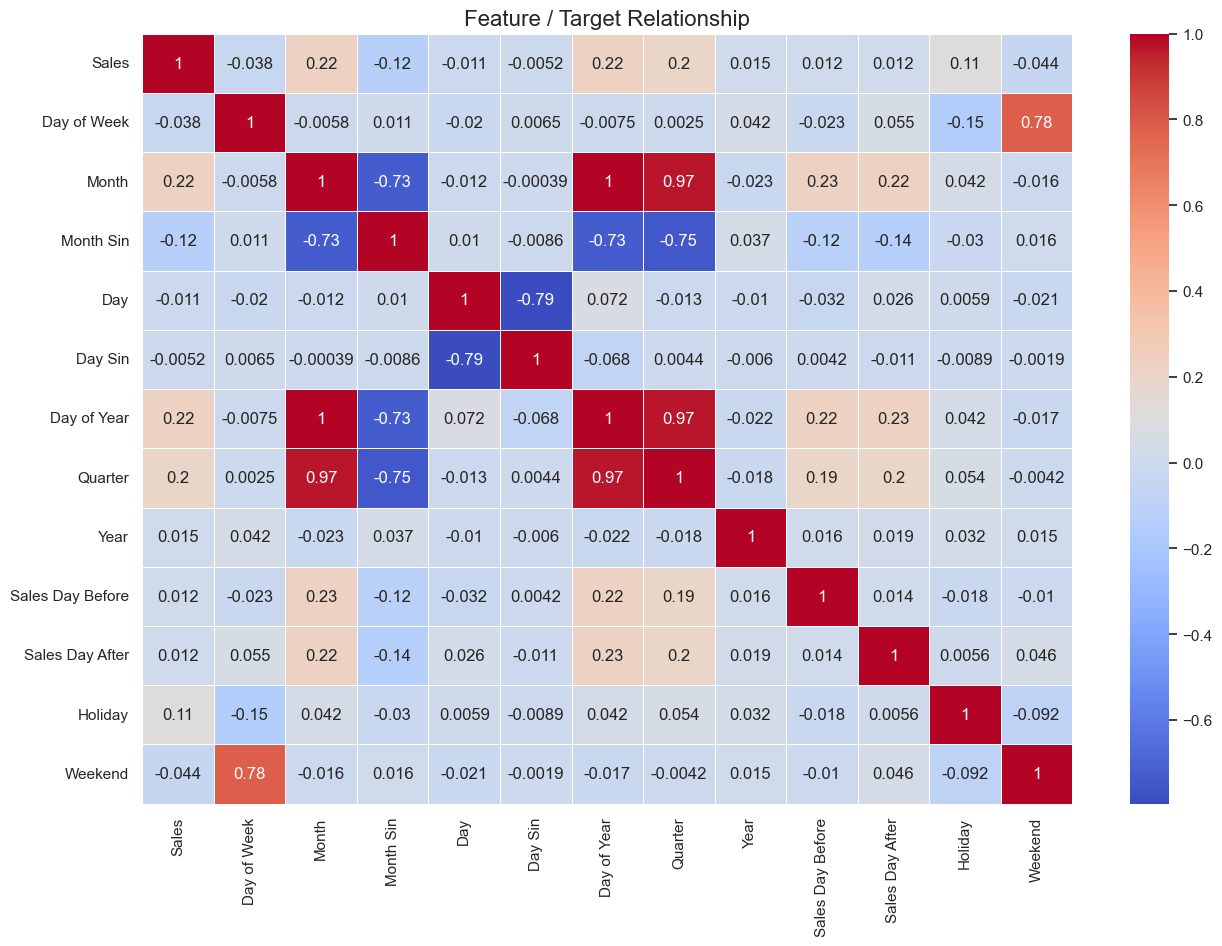

In [25]:
plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)

plt.title("Feature / Target Relationship", fontsize=16)

plt.show();

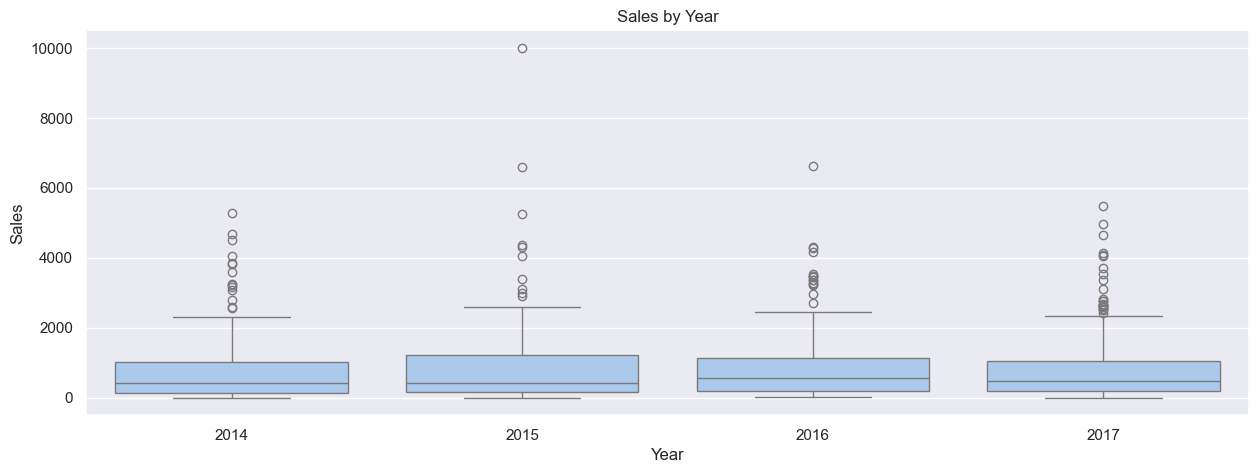

In [26]:
plt.figure(figsize=(15, 5))
sns.boxplot(df, x="Year", y="Sales")

plt.title("Sales by Year")
plt.xlabel("Year")
plt.ylabel("Sales")

plt.show();

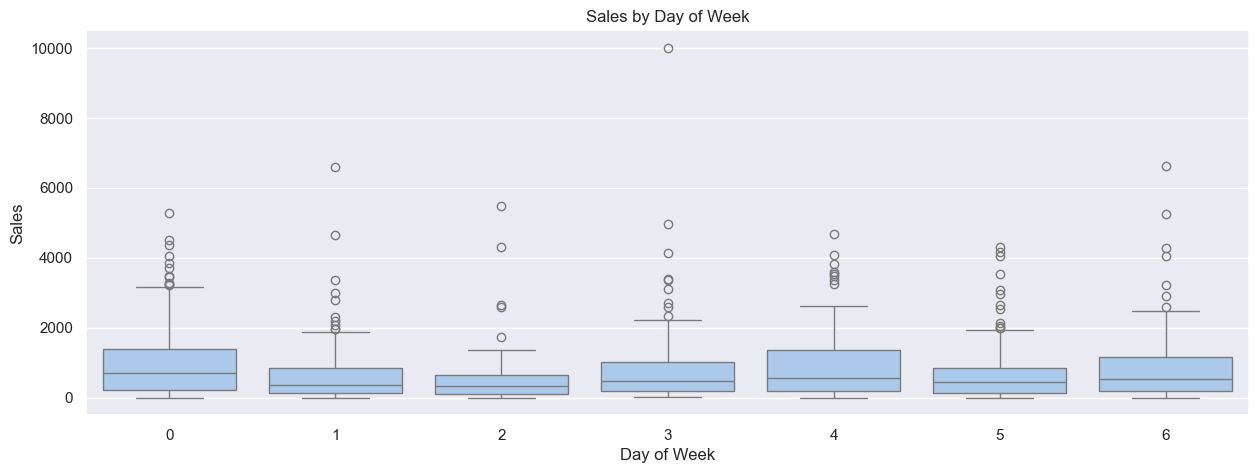

In [27]:
plt.figure(figsize=(15, 5))
sns.boxplot(df, x="Day of Week", y="Sales")

plt.title("Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Sales")

plt.show();

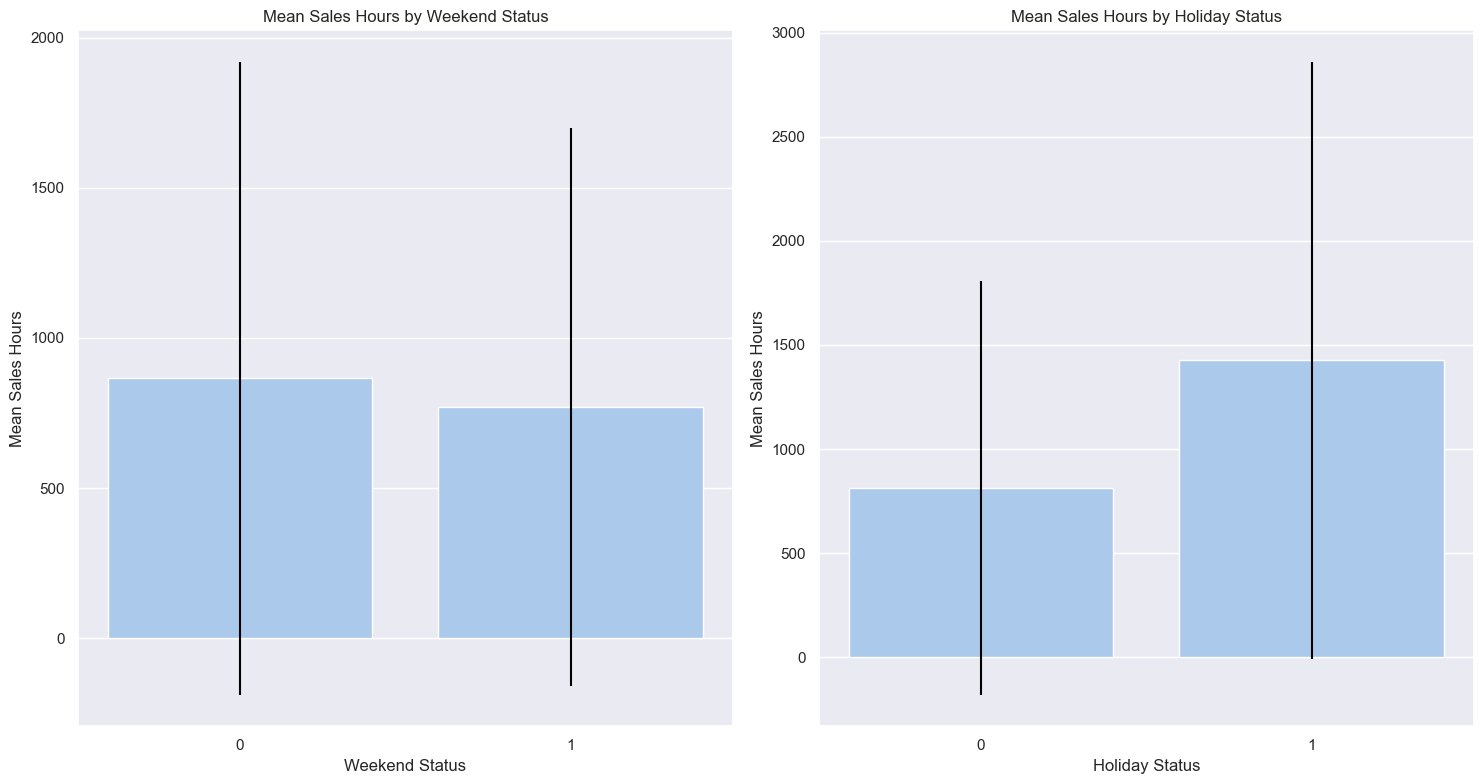

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 8))
groupings = [("Weekend", "Weekend Status"), ("Holiday", "Holiday Status")]

for i, (group, label) in enumerate(groupings):
    mean_sales = df.groupby(group)["Sales"].mean().reset_index()
    std_sales = df.groupby(group)["Sales"].std().reset_index()

    sns.barplot(mean_sales, x=group, y="Sales", ax=axs[i], errorbar="sd")

    axs[i].errorbar(
        mean_sales[group],
        mean_sales["Sales"],
        yerr=std_sales["Sales"],
        fmt="none",
        color="black",
    )

    axs[i].set_title(f"Mean Sales Hours by {label}")
    axs[i].set_xlabel(label)
    axs[i].set_ylabel("Mean Sales Hours")

plt.tight_layout()
plt.show();

## Create our Model

### Split the data

In [29]:
split_year = pd.to_datetime("2017-01-01")

train_df = df.query("index < @split_year")
test_df = df.query("index >= @split_year")

In [30]:
print(f"Train set size: {train_df.shape}")
print(f"Validation set size: {test_df.shape}")

Train set size: (631, 13)
Validation set size: (258, 13)


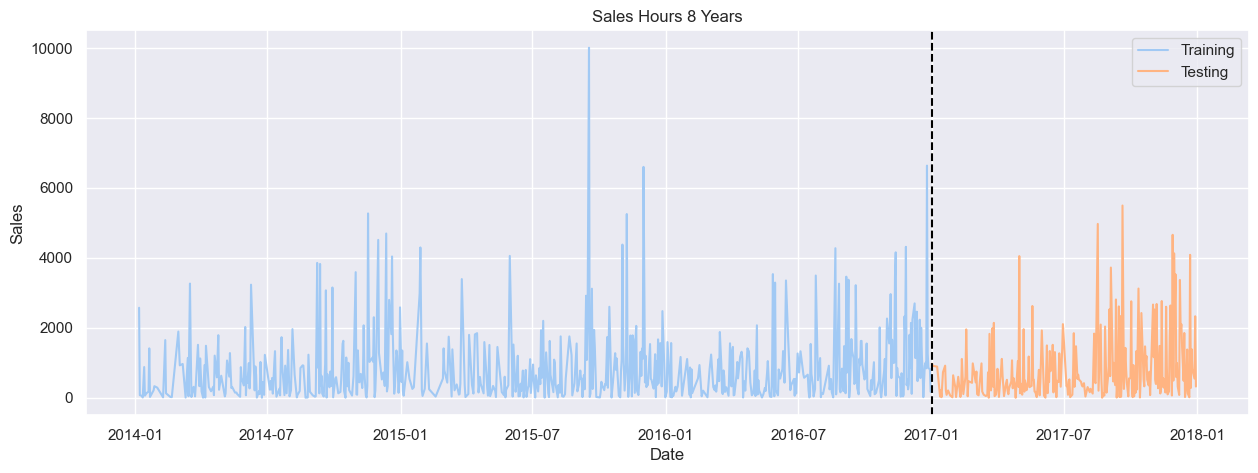

In [31]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=train_df.index, y=train_df["Sales"], label="Training")
sns.lineplot(x=test_df.index, y=test_df["Sales"], label="Testing")

plt.title("Sales Hours 8 Years")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.axvline(x=split_year, color="black", ls="--")

plt.show();

In [32]:
FEATURES = train_df.columns[1:]
TARGET = "Sales"

train_features, train_target = train_df[FEATURES], train_df[TARGET]
X_test, y_test = test_df[FEATURES], test_df[TARGET]

### Train the Model

In [33]:
model = XGBRegressor(random_state=42)

params = {
    "n_estimators": Integer(2000, 3000),
    "early_stopping_rounds": Integer(5, 15),
    "learning_rate": Real(0.01, 0.1),
    "max_depth": Integer(2, 5),
}

bayes_search = BayesSearchCV(
    estimator=model, search_spaces=params, cv=5, n_jobs=-1, random_state=42
)

In [34]:
%%time
bayes_search.fit(train_features, train_target,
                eval_set=[(X_test, y_test)],
                verbose=None);

CPU times: user 32.7 s, sys: 1.69 s, total: 34.4 s
Wall time: 44.1 s


In [35]:
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_
best_params

OrderedDict([('early_stopping_rounds', 7),
             ('learning_rate', 0.05965543339494371),
             ('max_depth', 3),
             ('n_estimators', 2418)])

### Evaluate the Model

In [36]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test))

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")

RMSE: 937.20
MAE: 663.74
MAPE: 860.99%


## Feature Importance

In [37]:
importances = best_model.feature_importances_
features = best_model.feature_names_in_

features_df = pd.DataFrame(
    {"Feature": features, "Importance": importances}
).sort_values("Importance", ascending=False)

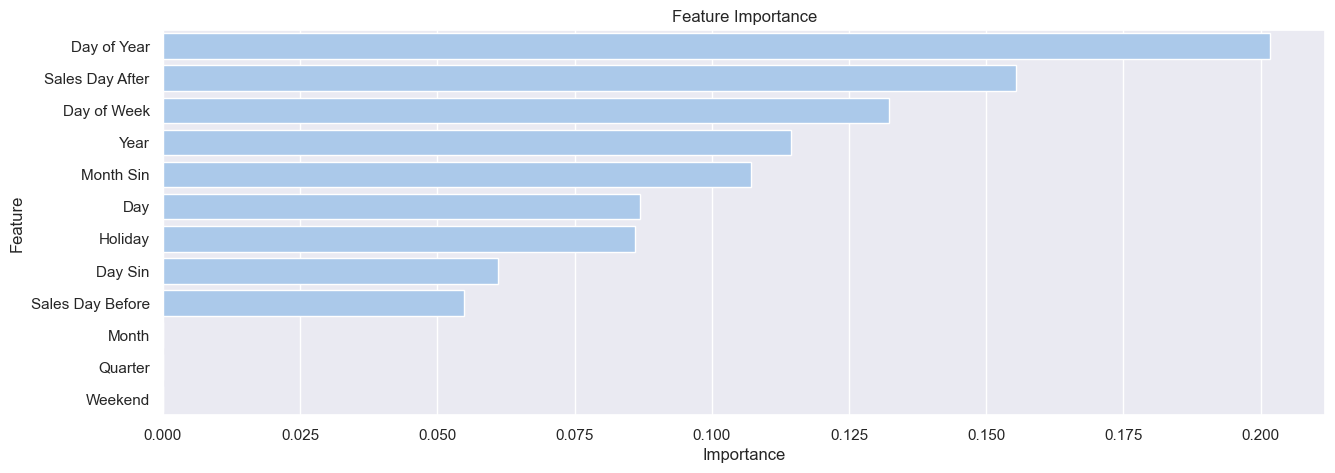

In [38]:
plt.figure(figsize=(15, 5))
sns.barplot(features_df, x="Importance", y="Feature")

plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.show()

## Save the model

In [39]:
import joblib

joblib.dump(best_model, "best_xgb_model.joblib")
print("XGBoost model saved as 'best_xgb_model.joblib'")

XGBoost model saved as 'best_xgb_model.joblib'
